In [13]:
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, SimpleRNN
from tensorflow.keras.layers import Embedding, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [48]:
df_train = pd.read_csv('Data/Corona_NLP_train.csv', index_col=0, encoding='latin-1')
df_test = pd.read_csv('Data/Corona_NLP_test.csv', index_col=0, encoding='latin-1')
df_train.head()

,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
UserName,,,,,
3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [54]:
labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
df_test['Sentiment_num'] = df_test['Sentiment'].apply(lambda x: labels.index(x))
df_train['Sentiment_num'] = df_train['Sentiment'].apply(lambda x: labels.index(x))
df_test[['Sentiment_num', 'Sentiment']]

,Sentiment_num,Sentiment
UserName,,
1,0,Extremely Negative
2,3,Positive
3,4,Extremely Positive
4,1,Negative
5,2,Neutral
...,...,...
3794,3,Positive
3795,1,Negative
3796,2,Neutral


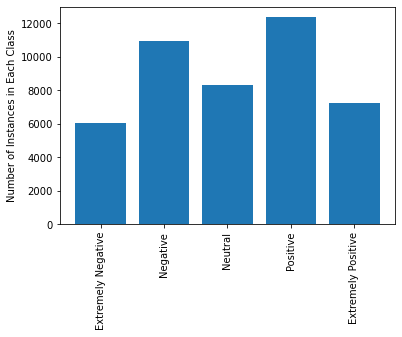

In [63]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 5

# print some stats of the data
unique, c_train = np.unique(df_train['Sentiment'], return_counts=True)
_, c_test = np.unique(df_test['Sentiment'], return_counts=True)
tot_counts = np.add(c_train, c_test) # Combine counts from both training and testing

idx = [0,2,3,4,1] # indexes so the instance counts are in order from extremely negative to extremely positive
plt.bar(list(range(NUM_CLASSES)),tot_counts[idx])
plt.xticks(list(range(NUM_CLASSES)), unique[idx], rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

In [ ]:
%%time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 300 # maximum number of words, max tweet length is 280 characters, added extra just in case

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df_train.OriginalTweet)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df_train.OriginalTweet)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X_train = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_train = df_train.Sentiment_num
print('Shape of data tensor:', X_train.shape)
print('Shape of label tensor:', y_train.shape)
print(np.max(X_train))

In [ ]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('Data/glove.6B.100d.txt', encoding="utf8")
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

36% is not very good. However, given that we are using tweets, which do include lots of abbreviations and misspellings, it's not surprising. We will explore using different embedding strategies later on.